In [3]:
import pandas as pd
import itertools
import numpy as np
import ocel 
import os
import pprint
from prettytable import PrettyTable
from IPython.display import display
import scipy.signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from pyclustering.cluster.optics import optics
from pylab import *
np.random.seed(1)
import pm4py
import json
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
from collections import defaultdict
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, confusion_matrix, precision_score, recall_score

In [4]:
##FILEPATHS##
bpi17 = 'BPIC17_offer_first5000traces.jsonocel'
bpi17_anomalies = 'BPIC17_offer_first5000traces_anomalous_app_objects.txt'
bpi15_10h_10p_6act = 'BPI15_1_10h_10p_6act.jsonocel'
bpi15_20h_top11 = 'BPIC15_Municipality1_Injected_Top11Activities.jsonocel'
bpi15_anomalies = 'BPI15_Municipality1_anomalycids.txt'
bpi15_10h_10p_top6_anomalies = 'BPI15_1_10h_10p_anomalous_app_objects.txt'

In [5]:
def preprocessing(dataset):
    objecttype = pm4py.ocel_get_object_types(dataset)[0]
    df1 = pm4py.ocel_flattening(dataset, objecttype)
    d = {}
    Z = {}
    remap_cIDs = []
    cIDs = df1["case:concept:name"].unique()
    for cID in cIDs:
        #act = df1.loc[df1["cID"] == cID, "event"]
        case = df1.loc[df1["case:concept:name"] == cID]   
        z = {}
        
        for (e1,e2) in list(itertools.combinations(range(len(case)), 2)):
            
            a1 = case.iloc[e1].loc["concept:name"]
            t1 = case.iloc[e1].loc["time:timestamp"]
            a2 = case.iloc[e2].loc["concept:name"]
            t2 = case.iloc[e2].loc["time:timestamp"]
            rel = a1+"->"+a2
            diff = (t2 - t1).total_seconds()
            if rel in d:
                d[rel].append(diff)
            else:
                d[rel] = [diff]
            z[rel] = diff
        Z[cID] = z
        
    avg = {}
    std = {}
    ext = {}

    for rel, values in d.items():
        avg[rel] = np.mean(values)
        std[rel] = np.std(values)
        ext[rel] = np.max(np.abs(values))
        

    rels = list(d.keys())


    test_time = []

        
    # standardizing
    Zstd = {}
    for cID, case in Z.items():
        vstd = {}
        for rel, value in case.items():
            vstd[rel] = (value-avg[rel])
            if std[rel] == 0:
                vstd[rel] = 0
            else:
                vstd[rel] /= std[rel]
        Zstd[cID] = vstd
        
    cIDs = Z.keys()

    Zvectors = []

    for cID in cIDs:
        
        temp = Zstd[cID]
        dummy = []
        for rel in rels:
            if rel in temp:
                dummy.append(temp[rel])
            else:
                dummy.append(0.0)
        Zvectors.append(dummy)
        remap_cIDs.append(cID)

    print("Number of traces: ", len(Zvectors))
    print("Number of relations: ", len(rels))
    
    return Zvectors, remap_cIDs, rels

In [6]:
def anomaly_detection(Zvectors, remap_cIDs, rels, minpts, eps, prominence):    
    #params
    #################
    # eps = 30
    # prominence = 1
    #################
    optics_instance = optics(Zvectors, eps, minpts)

    optics_instance.process()

    clusters = optics_instance.get_clusters()
    noise = optics_instance.get_noise()

    reach = pd.Series(optics_instance.get_ordering())
    left = max(reach)

    reach_smoothed = scipy.signal.savgol_filter(reach, 5, 3)

    if(len(reach)%2 == 0):
        l = len(reach)-1
    else:
        l = len(reach)-2

    yhat = scipy.signal.savgol_filter(reach, l, 5)



    coord1 = [np.array((x,reach_smoothed[x])) for x in range(len(reach_smoothed))]
    coord2 = [np.array((x,yhat[x])) for x in range(len(yhat))]


    diffy = (yhat-reach_smoothed)*yhat


    yhatclip = np.clip(diffy, 0, np.max(diffy))


    peaks, properties = find_peaks(yhatclip, prominence=prominence, width=minpts/2.0)


    cc = {}
    cluster_objects_ids = {}
    entropy_all = {}

    outliers_list = []

    clusters = [val for sublist in clusters for val in sublist]

    for k in range(len(peaks)):
        left = np.ceil(properties["left_ips"][k])
        right = np.floor(properties["right_ips"][k])
        cc[k] = [clusters[l] for l in range(int(left),int(right))]
        
        outliers_list.extend(cc[k])
        cluster = [Zvectors[l] for l in cc[k]]
        
        cluster_objects_ids[k] = [remap_cIDs[o] for o in cc[k]]
        
        entropies = []
        for i in range(len(rels)):
            rel = rels[i]
            e = np.std([v[i] for v in cluster])
            mean = np.mean([v[i] for v in cluster])
            
            entropies.append((e,rel, mean))
            
        entropy_all[k] = entropies
        
    fig, ax1 = plt.subplots(figsize=(8,2))
    #fig = plt.figure(figsize=(8, 4), dpi=dpi)

    plt.plot(reach_smoothed)
    plt.plot(yhat, color='red')

    if len(peaks) == 1:
        xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
        ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)
    elif len(peaks) > 1:
        for i in range(len(peaks)):
            xs = np.arange(int(properties["left_ips"][i]), int(properties["right_ips"][i]), 1)
            ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"][i]):int(properties["right_ips"][i])], yhat[int(properties["left_ips"][i]):int(properties["right_ips"][i])], color='00', alpha=0.3) 
    #plt.vlines(x=peaks, ymin=reach_smoothed[peaks], ymax = yhat[peaks], color = "C1")
    #plt.hlines(y=reach_smoothed[peaks], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")
    plt.title('TOAD plot')
    plt.ylabel('Reachability Distance')
    plt.xlabel('Traces')
    plt.show()
    predicted_anomalies = []
    for x in cluster_objects_ids.keys():
        for entry in cluster_objects_ids[x]:
            predicted_anomalies.append(entry)
    return predicted_anomalies


In [7]:
def read_anomaly_list(filepath):    
    # opening the file in read mode 
    my_file = open(filepath, "r") 
    
    # reading the file 
    anomalycids = my_file.read() 
    
    # replacing end splitting the text  
    # when newline ('\n') is seen. 
    anomalycids_list = anomalycids.split("\n")
    for x in anomalycids_list:
        if x == '':
            anomalycids_list.remove(x) 
    #print(anomalycids_list) 
    my_file.close()
    
    return anomalycids_list

In [8]:
def listObjectIds(targetDataset, ocel): 
    object_type = pm4py.ocel_get_object_types(ocel)[0] 
    objectIDs = []
    for object in targetDataset['ocel:objects']:
        if targetDataset['ocel:objects'][object]['ocel:type'] == object_type:
            objectIDs.append(object)
    objectIDs = list(set(objectIDs)) 
    return objectIDs     

In [4]:
def dict_to_df(dictionary):    
    list_of_lists = []
    data = dictionary
    for event in data['ocel:events']:
        attributes = []
        attributes.append(event)
        attributes.append(data['ocel:events'][event]['ocel:timestamp'])
        attributes.append(data['ocel:events'][event]['ocel:vmap']['cID'])
        attributes.append(data['ocel:events'][event]['ocel:omap'])
        list_of_lists.append(attributes)
    df = pd.DataFrame(list_of_lists, columns=['Event', 'Timestamp', 'Case ID', 'Object Mapping'])
    return df

In [11]:
def metrics(data_filepath, anomaly_filepath, eps, prom):
    data_ocel = pm4py.read_ocel(data_filepath)
    with open(data_filepath, 'r') as file:
        targetDataset = json.load(file)
    #Parameters
    minpoints = [5, 10, 15, 20, 25]#[15, 17, 20, 25]#[2, 4, 5, 10, 15] #[5, 10, 15, 20, 25, 30, 35, 40, 45, 60]
    #objecttype = 'Offer'
    #true labels
    y_true = []
    #list of all case ids
    cids = listObjectIds(targetDataset, data_ocel)
    anomaly_cids = read_anomaly_list(anomaly_filepath)
    for cid in cids:
        if str(cid) in anomaly_cids:
            y_true.append(1)
        else:
            y_true.append(0)
    #counter depicting the number of times each case id has been identified as anomalous
    anomaly_counts = np.zeros(len(cids))
    #F1-Score for each minpoints value
    f1_scores = []
    precisionlist = []
    recalllist = []
    y_preds = []
    pp_results = preprocessing(data_ocel)          
    for minPts in minpoints:
        predAnomalies = anomaly_detection(pp_results[0], pp_results[1], pp_results[2], minPts, eps, prom)
        y_pred = []
        for cid in cids:
            if cid in predAnomalies:
                y_pred.append(1)
            else:
                y_pred.append(0)
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
        anomaly_counts += y_pred
        y_preds.append(y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        print('F1-Score for minpts value ' + str(minPts) + ':' )
        display(f1)
        print('Precision-Score for minpts value ' + str(minPts) + ':' )
        display(precision)
        precisionlist.append(float(precision))
        recalllist.append(float(recall))
        print('Recall-Score for minpts value ' + str(minPts) + ':' )
        display(recall)
        #display(y_pred)
            
    #Normalize anomaly counts to get continuous anomaly scores for the auc calculations
    anomaly_scores = anomaly_counts / len(minpoints)
    #AUC ROC score
    rocauc = float(roc_auc_score(y_true, anomaly_scores))
    #AUC PR score
    aucpr = float(average_precision_score(y_true, anomaly_scores))
    #Mean of F1-Scores
    mean_f1 = float(np.mean(f1_scores))
    
    print('AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: ')
    display(rocauc)
    print('AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: ')
    display(aucpr)
    print('Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: ') 
    display(mean_f1)
    mean_precision = float(np.mean(precisionlist))
    mean_recall = float(np.mean(recalllist))
    results_dict = {'F1': round(mean_f1,2),
                    'AUC ROC': round(rocauc,2),
                    'AUC Precision-Recall': round(aucpr,2),
                    'Mean Precision' : round(mean_precision,2),
                    'Mean Recall' : round(mean_recall,2)
                    }
    results_df = pd.DataFrame([results_dict], index=[0])
    return results_df

Number of traces:  5000
Number of relations:  24


C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


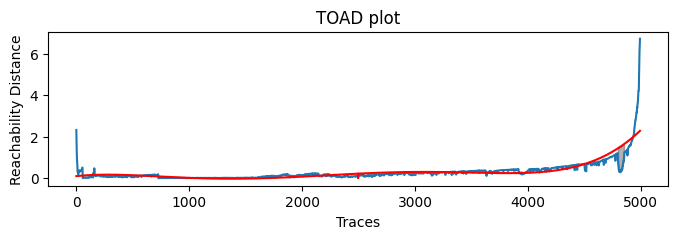

F1-Score for minpts value 5:


np.float64(0.5584415584415584)

Precision-Score for minpts value 5:


np.float64(0.8113207547169812)

Recall-Score for minpts value 5:


np.float64(0.42574257425742573)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


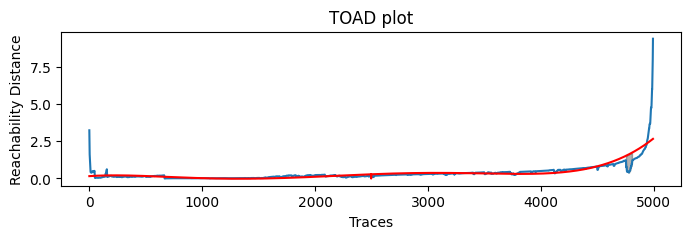

F1-Score for minpts value 10:


np.float64(0.5584415584415584)

Precision-Score for minpts value 10:


np.float64(0.8113207547169812)

Recall-Score for minpts value 10:


np.float64(0.42574257425742573)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


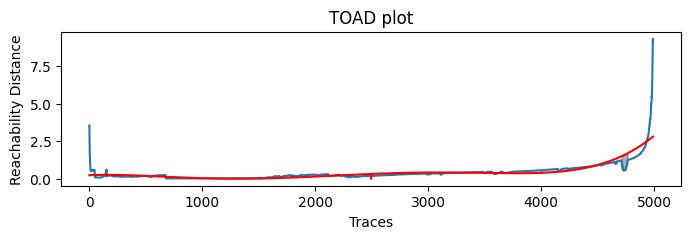

F1-Score for minpts value 15:


np.float64(0.5866666666666667)

Precision-Score for minpts value 15:


np.float64(0.8979591836734694)

Recall-Score for minpts value 15:


np.float64(0.43564356435643564)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


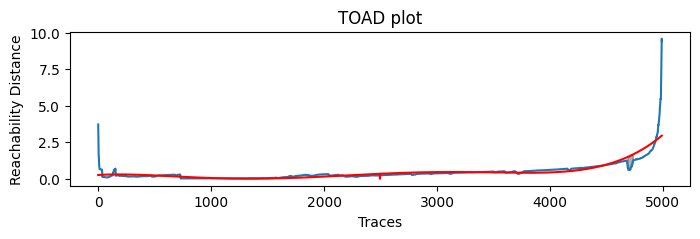

F1-Score for minpts value 20:


np.float64(0.5675675675675675)

Precision-Score for minpts value 20:


np.float64(0.8936170212765957)

Recall-Score for minpts value 20:


np.float64(0.4158415841584158)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


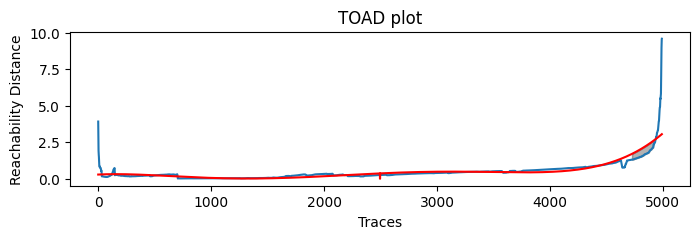

F1-Score for minpts value 25:


np.float64(0.020689655172413793)

Precision-Score for minpts value 25:


np.float64(0.015873015873015872)

Recall-Score for minpts value 25:


np.float64(0.0297029702970297)

AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.7211109965864927

AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.40416838273199296

Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.45836140125795294

In [15]:
ansatz1_bpi17results = metrics(bpi17, bpi17_anomalies, 10, 1.2)

In [16]:
ansatz1_bpi17results.to_csv('results/ansatz1_bpi17results.csv', index=False)

Number of traces:  1199
Number of relations:  33


C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


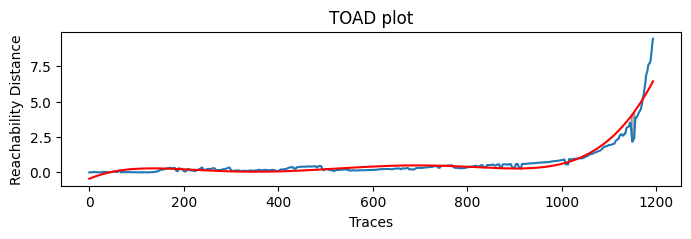

F1-Score for minpts value 5:


np.float64(0.05714285714285714)

Precision-Score for minpts value 5:


np.float64(0.42857142857142855)

Recall-Score for minpts value 5:


np.float64(0.030612244897959183)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


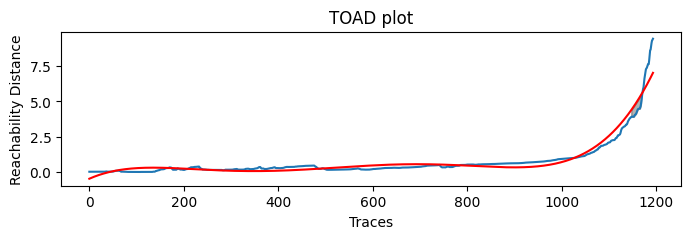

F1-Score for minpts value 10:


np.float64(0.05042016806722689)

Precision-Score for minpts value 10:


np.float64(0.14285714285714285)

Recall-Score for minpts value 10:


np.float64(0.030612244897959183)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


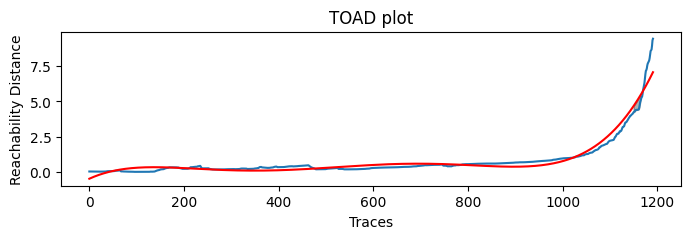

F1-Score for minpts value 15:


np.float64(0.05357142857142857)

Precision-Score for minpts value 15:


np.float64(0.21428571428571427)

Recall-Score for minpts value 15:


np.float64(0.030612244897959183)

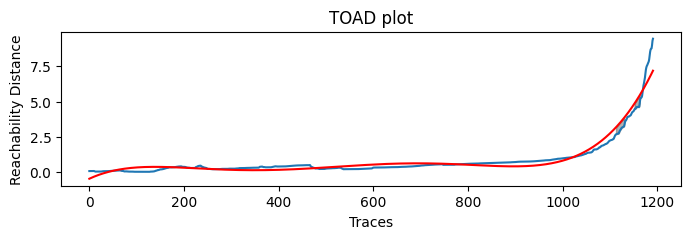

F1-Score for minpts value 20:


np.float64(0.015873015873015872)

Precision-Score for minpts value 20:


np.float64(0.03571428571428571)

Recall-Score for minpts value 20:


np.float64(0.01020408163265306)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


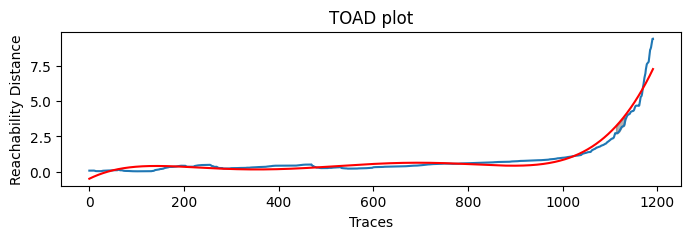

F1-Score for minpts value 25:


np.float64(0.0)

Precision-Score for minpts value 25:


np.float64(0.0)

Recall-Score for minpts value 25:


np.float64(0.0)

AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.5020157926930991

AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.0851446973006606

Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.0354014939309057

In [10]:
ansatz1_bpi15_20results = metrics('BPIC15_1_20h_20p_6act.jsonocel', 'BPIC15_1_20h_20p_6act_anomalous_app_objects.txt', 10, 1.2)

In [12]:
ansatz1_bpi15_20results.to_csv('results/ansatz1_bpi15_20results.csv', index=False)

Number of traces:  1199
Number of relations:  32


C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


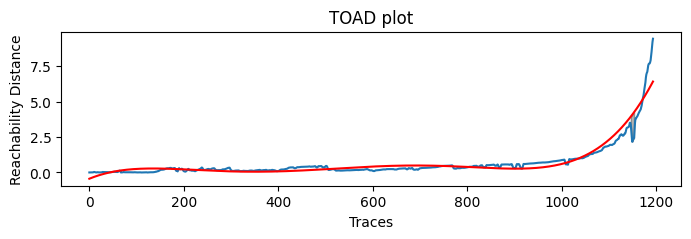

F1-Score for minpts value 5:


np.float64(0.07142857142857142)

Precision-Score for minpts value 5:


np.float64(0.2857142857142857)

Recall-Score for minpts value 5:


np.float64(0.04081632653061224)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


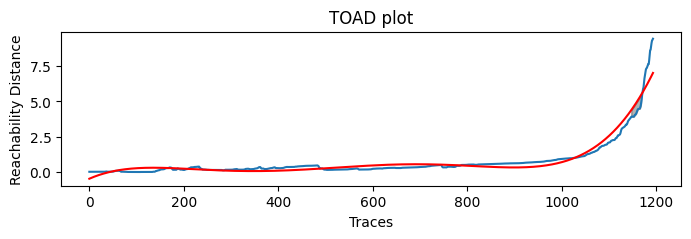

F1-Score for minpts value 10:


np.float64(0.05714285714285714)

Precision-Score for minpts value 10:


np.float64(0.09523809523809523)

Recall-Score for minpts value 10:


np.float64(0.04081632653061224)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


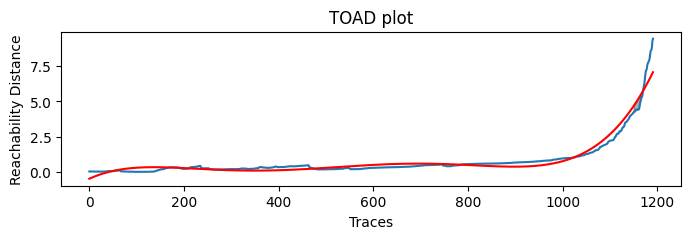

F1-Score for minpts value 15:


np.float64(0.06349206349206349)

Precision-Score for minpts value 15:


np.float64(0.14285714285714285)

Recall-Score for minpts value 15:


np.float64(0.04081632653061224)

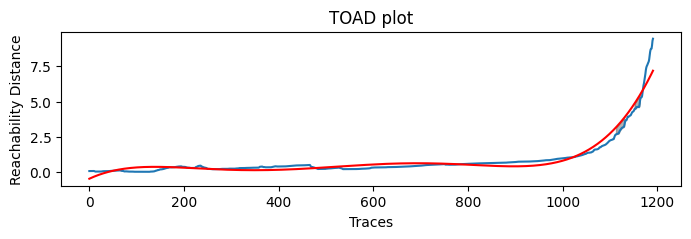

F1-Score for minpts value 20:


np.float64(0.0)

Precision-Score for minpts value 20:


np.float64(0.0)

Recall-Score for minpts value 20:


np.float64(0.0)

C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_6528\2024064255.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


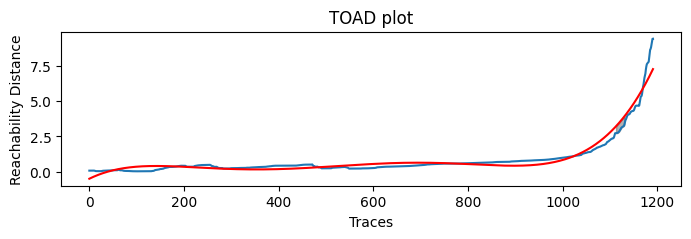

F1-Score for minpts value 25:


np.float64(0.0)

Precision-Score for minpts value 25:


np.float64(0.0)

Recall-Score for minpts value 25:


np.float64(0.0)

AUC ROC Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.5124223602484472

AUC PR Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.043353966551869565

Mean F1-Score for minPts [5, 15, 25, 30, 35, 40, 45, 60] is: 


0.03841269841269841

In [13]:
ansatz1_bpi15_10results = metrics('BPI15_1_10h_10p_6act.jsonocel', 'BPI15_1_10h_10p_anomalous_app_objects.txt', 10, 1.2)

In [14]:
ansatz1_bpi15_10results.to_csv('results/ansatz1_bpi15_10results.csv', index=False)